In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from warnings import simplefilter, filterwarnings
filterwarnings("ignore", category=FutureWarning)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
patients = ['001', '002', '004', '006', '007', '008']
features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins', 'fast_insulin', 'slow_insulin']

In [3]:
def get_projected_value(window, prediction_horizon):
    x = np.arange(len(window))
    coeffs = np.polyfit(x, window, deg=3)
    poly = np.poly1d(coeffs)
    projected_value = poly(len(window) + prediction_horizon)
    return projected_value


def get_data(patient, food_data, prediction_horizon):
    glucose_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/glucose.csv")
    insulin_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/insulin.csv")

    glucose_data["datetime"] = pd.to_datetime(glucose_data["date"] + ' ' + glucose_data["time"])
    glucose_data.drop(['type', 'comments', 'date', 'time'], axis=1, inplace=True)
    glucose_data['glucose'] *= 18.0182  # Convert to mg/dL

    insulin_data["datetime"] = pd.to_datetime(insulin_data["date"] + ' ' + insulin_data["time"])
    insulin_data.drop(['comment', 'date', 'time'], axis=1, inplace=True)

    food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
    food_data = food_data[['datetime', 'simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers']]

    combined_data = pd.concat([food_data, insulin_data]).sort_values('datetime').reset_index(drop=True)
    combined_data.fillna(0, inplace=True)
    glucose_data['hour'] = glucose_data['datetime'].dt.hour

    glucose_data['glucose_next'] = glucose_data['glucose'] - glucose_data['glucose'].shift(-prediction_horizon)

    glucose_data['glucose_change'] = glucose_data['glucose'] - glucose_data['glucose'].shift(1)

    glucose_data[f'glucose_change_sh_3'] = glucose_data['glucose_change'].shift(3)

    for window in [2, 3, 6]:
        glucose_data[f'glucose_change_std_{window}'] = glucose_data['glucose_change'].rolling(window=window).std()
    
    delta = glucose_data['glucose'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=6).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=6).mean()
    glucose_data['glucose_rsi'] = 100 - (100 / (1 + gain / loss))

    glucose_data['glucose_change_projected'] = glucose_data['glucose_change'].rolling(
        window=6, min_periods=6
    ).apply(lambda window: get_projected_value(window, prediction_horizon))
    glucose_data['glucose_projected'] = glucose_data['glucose'].rolling(
        window=6, min_periods=6
    ).apply(lambda window: get_projected_value(window, prediction_horizon))
    glucose_data.dropna(subset=['glucose_next'], inplace=True)
    return glucose_data, combined_data

def calculate_weights(time_diff_hours, metabolism_rate, peak_time):
    weights = np.zeros_like(time_diff_hours)
    increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
    plateau_duration = 0.25
    weights[increase_mask] = time_diff_hours[increase_mask] / peak_time
    plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
    weights[plateau_mask] = 1
    decrease_mask = time_diff_hours >= peak_time + plateau_duration
    weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration) * metabolism_rate)
    return np.clip(weights, 0, None)


def add_features(params, features, preprocessed_data, prediction_horizon):
    glucose_data, combined_data = preprocessed_data
    
    glucose_times = glucose_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
    combined_times = combined_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
    for feature in features:
        metabolism_rate, peak_time = params[feature]
        time_diff_hours = ((glucose_times[:, None] - combined_times[None, :]) / 3600)
        weights = np.zeros_like(time_diff_hours)
        increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
        weights[increase_mask] = time_diff_hours[increase_mask] / peak_time
        plateau_duration = 0.25
        plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
        weights[plateau_mask] = 1
        decrease_mask = time_diff_hours >= peak_time + plateau_duration
        weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration) * metabolism_rate)
        weights = np.clip(weights, 0, None)
        glucose_data[feature] = np.dot(weights, combined_data.loc[:, feature].values)
        glucose_data[feature] = glucose_data[feature] - glucose_data[feature].shift(-prediction_horizon) + glucose_data['glucose_change']
    glucose_data.dropna(inplace=True)
    return glucose_data

In [4]:
approach = 'gpt4o'
prediction_horizon = 6
patient = '001'
food_data = pd.read_csv(f"food_data/{approach}/{patient}.csv")
features_to_remove = ['glucose_next', 'datetime']
feature_params = {
    'simple_sugars': [0.5, 0.5],  # [insulin_sensitivity_param, peak_time]
    'complex_sugars': [0.3, 0.5],
    'proteins': [0.2, 3.5],
    'fats': [0.05, 3.5], 
    'dietary_fibers': [0.05, 3.5],
    'fast_insulin': [1.0, 0.5], 
    'slow_insulin': [0.5, 1.0]
}

In [5]:
def modify_macronutrients(food_data, nutrient, amount):
    """Modify a specific macronutrient by a given amount."""
    modified_food_data = food_data.copy()
    modified_food_data[nutrient] += amount
    # Ensure values remain non-negative
    modified_food_data[nutrient] = modified_food_data[nutrient].clip(lower=0)
    return modified_food_data

In [11]:
# Create DataFrame to store results
results_df = pd.DataFrame(columns=['feature', 'increment', 'hyper_minutes', 'hypo_minutes', 'mean_glucose', 'patient'])
meal_features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins']
increments = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50] 
# Simulate additions/subtractions for each feature
for feature in meal_features:
    for increment in increments:
        patient_hyper_times = []
        patient_hypo_times = []
        patient_means = []
        for patient in patients:
            # Load patient model
            model = joblib.load(f'models/{approach}/6_1_{patient}.joblib')

            # Get modified predictions
            modified_food_data = modify_macronutrients(food_data, feature, increment)
            data_modified = get_data(patient, modified_food_data, prediction_horizon)
            test_modified = add_features(feature_params, features, data_modified, prediction_horizon)
            X_test_modified = test_modified.drop(features_to_remove, axis=1)
            preds_modified = X_test_modified['glucose'] - model.predict(X_test_modified)

            # Convert predictions to binary indicators and calculate time in minutes
            hyper_binary_preds = (preds_modified >= 180).astype(int)
            hypo_binary_preds = (preds_modified <= 70).astype(int)
            
            hyperglycemia_count = np.sum(hyper_binary_preds)
            hypoglycemia_count = np.sum(hypo_binary_preds)
            
            hyperglycemia_hours = hyperglycemia_count / 12
            hypoglycemia_hours = hypoglycemia_count / 12
            
            patient_hyper_times.append(hyperglycemia_hours)
            patient_hypo_times.append(hypoglycemia_hours)
            patient_means.append(np.mean(preds_modified))

            # Average time and glucose levels across patients
            total_hyper_time = np.mean(patient_hyper_times)
            total_hypo_time = np.mean(patient_hypo_times)
            mean_glucose = np.mean(patient_means)

            # Store in DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                'feature': [feature],
                'increment': [increment],
                'hyper_minutes': [total_hyper_time],
                'hypo_minutes': [total_hypo_time],
                'mean_glucose': [mean_glucose],
                'patient': [patient]
            })])

# Pivot the DataFrame for easier calculations
hyper_pivot_df = results_df.pivot_table(index='increment', columns='feature', values='hyper_minutes', aggfunc='mean')
hypo_pivot_df = results_df.pivot_table(index='increment', columns='feature', values='hypo_minutes', aggfunc='mean')
glucose_pivot_df = results_df.pivot_table(index='increment', columns='feature', values='mean_glucose', aggfunc='mean')

# Get the baseline values at increment = 0
hyper_baseline = hyper_pivot_df.loc[0]
hypo_baseline = hypo_pivot_df.loc[0]
glucose_baseline = glucose_pivot_df.loc[0]

# Calculate the difference from the baseline
hyper_difference_df = hyper_pivot_df.subtract(hyper_baseline, axis='columns').reset_index()
hypo_difference_df = hypo_pivot_df.subtract(hypo_baseline, axis='columns').reset_index()
glucose_difference_df = glucose_pivot_df.subtract(glucose_baseline, axis='columns').reset_index()

In [262]:
results_df.loc[(results_df['feature'] == 'fats') & (results_df['increment'] == 50), 'mean_glucose'] - glucose_baseline.values[0]

0    -2.886480
0     2.811523
0     4.650915
0     0.296342
0    -6.001883
0   -13.389951
Name: mean_glucose, dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


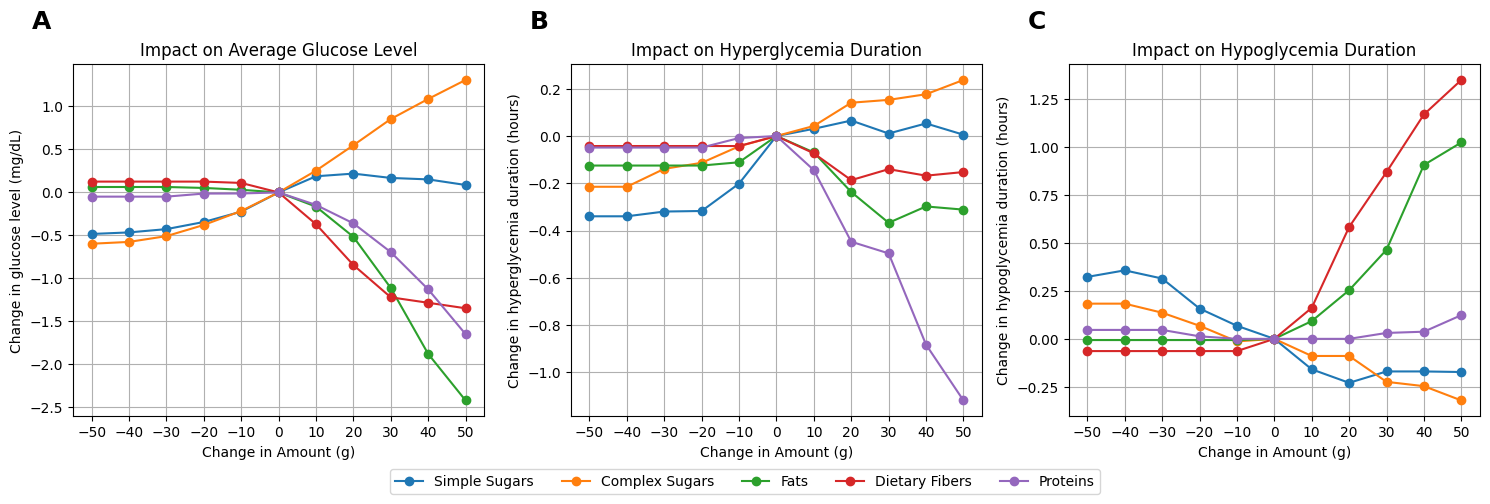

In [263]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Add bold A, B and C labels
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=18, fontweight='bold')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=18, fontweight='bold')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=18, fontweight='bold')

# Plot mean glucose changes
for feature in meal_features:
    ax1.plot(
        glucose_difference_df['increment'],
        glucose_difference_df[feature],
        'o-',
        label=feature.replace('_', ' ').title()
    )

ax1.set_xlabel('Change in Amount (g)')
ax1.set_ylabel('Change in glucose level (mg/dL)')
ax1.set_title('Impact on Average Glucose Level')
ax1.grid(True)
ax1.set_xticks(increments)

# Plot hyperglycemia
for feature in meal_features:
    ax2.plot(
        hyper_difference_df['increment'],
        hyper_difference_df[feature],
        'o-',
        label=feature.replace('_', ' ').title()
    )

ax2.set_xlabel('Change in Amount (g)')
ax2.set_ylabel('Change in hyperglycemia duration (hours)')
ax2.set_title('Impact on Hyperglycemia Duration')
ax2.grid(True)
ax2.set_xticks(increments)

# Plot hypoglycemia
for feature in meal_features:
    ax3.plot(
        hypo_difference_df['increment'],
        hypo_difference_df[feature],
        'o-',
        label=feature.replace('_', ' ').title()
    )

ax3.set_xlabel('Change in Amount (g)')
ax3.set_ylabel('Change in hypoglycemia duration (hours)')
ax3.set_title('Impact on Hypoglycemia Duration')
ax3.grid(True)
ax3.set_xticks(increments)



# Add single legend at the bottom
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=len(meal_features))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.savefig('paper_images/nutrient_glycemia_difference.eps', format='eps')
plt.show()

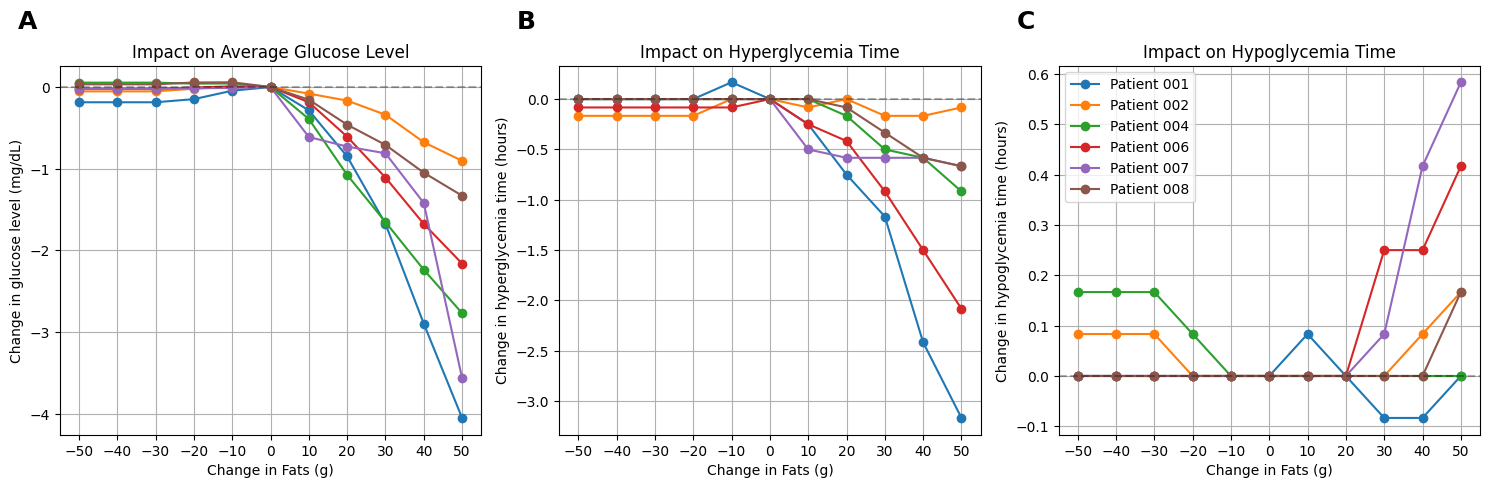

In [31]:
# Create DataFrame to store results
results_df = pd.DataFrame(columns=['feature', 'increment', 'hyper_minutes', 'hypo_minutes', 'mean_glucose', 'patient'])
feature = 'proteins'  # Only analyze fats

for increment in increments:
    for patient in patients:
        # Load patient model
        model = joblib.load(f'models/{approach}/6_1_{patient}.joblib')

        # Get modified predictions
        modified_food_data = modify_macronutrients(food_data, feature, increment)
        data_modified = get_data(patient, modified_food_data, prediction_horizon)
        test_modified = add_features(feature_params, features, data_modified, prediction_horizon)
        X_test_modified = test_modified.drop(features_to_remove, axis=1)
        preds_modified = X_test_modified['glucose'] - model.predict(X_test_modified)

        # Convert predictions to binary indicators and calculate time in hours
        hyper_binary_preds = (preds_modified >= 180).astype(int)
        hypo_binary_preds = (preds_modified <= 70).astype(int)
        
        hyperglycemia_hours = np.sum(hyper_binary_preds) / 12
        hypoglycemia_hours = np.sum(hypo_binary_preds) / 12
        mean_glucose = np.mean(preds_modified)

        # Store in DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({
            'feature': [feature],
            'increment': [increment],
            'hyper_minutes': [hyperglycemia_hours],
            'hypo_minutes': [hypoglycemia_hours],
            'mean_glucose': [mean_glucose],
            'patient': [patient]
        })])

# Calculate relative changes for each patient
for patient in patients:
    # Get baseline values (increment = 0) for this patient
    baseline_mask = (results_df['patient'] == patient) & (results_df['increment'] == 0)
    hyper_baseline = results_df.loc[baseline_mask, 'hyper_minutes'].values[0]
    hypo_baseline = results_df.loc[baseline_mask, 'hypo_minutes'].values[0]
    glucose_baseline = results_df.loc[baseline_mask, 'mean_glucose'].values[0]
    
    # Calculate relative changes
    mask = results_df['patient'] == patient
    results_df.loc[mask, 'hyper_minutes'] = results_df.loc[mask, 'hyper_minutes'] - hyper_baseline
    results_df.loc[mask, 'hypo_minutes'] = results_df.loc[mask, 'hypo_minutes'] - hypo_baseline
    results_df.loc[mask, 'mean_glucose'] = results_df.loc[mask, 'mean_glucose'] - glucose_baseline

# Create the plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Add bold A, B and C labels
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=18, fontweight='bold')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=18, fontweight='bold')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=18, fontweight='bold')

# Plot individual patient results
for patient in patients:
    patient_data = results_df[results_df['patient'] == patient]
    
    ax1.plot(patient_data['increment'], patient_data['mean_glucose'], 
             'o-', label=f'Patient {patient}')
    ax2.plot(patient_data['increment'], patient_data['hyper_minutes'], 
             'o-', label=f'Patient {patient}')
    ax3.plot(patient_data['increment'], patient_data['hypo_minutes'], 
             'o-', label=f'Patient {patient}')

# Customize plots
ax1.set_xlabel('Change in Fats (g)')
ax1.set_ylabel('Change in glucose level (mg/dL)')
ax1.set_title('Impact on Average Glucose Level')
ax1.grid(True)
ax1.set_xticks(increments)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)

ax2.set_xlabel('Change in Fats (g)')
ax2.set_ylabel('Change in hyperglycemia time (hours)')
ax2.set_title('Impact on Hyperglycemia Time')
ax2.grid(True)
ax2.set_xticks(increments)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)

ax3.set_xlabel('Change in Fats (g)')
ax3.set_ylabel('Change in hypoglycemia time (hours)')
ax3.set_title('Impact on Hypoglycemia Time')
ax3.grid(True)
ax3.set_xticks(increments)
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

## Glucovision

In [264]:
def modify_macronutrients(food_data, nutrient, amount, meal_time):
    modified_food_data = food_data.copy()
    # Find the meal closest to the specified meal_time
    time_diffs = abs(modified_food_data['datetime'] - meal_time)
    meal_index = time_diffs.idxmin()
    # Modify the nutrient for that meal
    modified_food_data.loc[meal_index, nutrient] += amount
    # Ensure values remain non-negative
    modified_food_data[nutrient] = modified_food_data[nutrient].clip(lower=0)
    return modified_food_data

In [305]:
patient = '004'
food_data = pd.read_csv(f"food_data/{approach}/{patient}.csv")
# Initialize variables to track the best combination
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
meal_time = food_data.loc[food_data['picture'] == '004.jpg', 'datetime'].values[0]

meal_features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins']
increments = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]

# Load model once instead of in the loop
model = joblib.load(f'models/{approach}/6_1_{patient}.joblib')

# Get baseline prediction
data_baseline = get_data(patient, food_data, prediction_horizon)
test_baseline = add_features(feature_params, features, data_baseline, prediction_horizon)

# Get timestamps within 30 minutes after meal
time_diffs = test_baseline['datetime'] - meal_time
valid_times = (time_diffs >= pd.Timedelta(minutes=0)) & (time_diffs <= pd.Timedelta(minutes=30))
test = pd.DataFrame(test_baseline[valid_times].iloc[-1]).T

# Convert all columns to numeric before prediction
numeric_cols = test.select_dtypes(include=['object']).columns
for col in numeric_cols:
    test[col] = pd.to_numeric(test[col], errors='coerce')

X_test = test.drop(features_to_remove, axis=1)
preds_baseline = test['glucose'].values[0] - model.predict(X_test)
print(f"Baseline predicted glucose: {preds_baseline[0]:.2f} mg/dL")

Baseline predicted glucose: 308.96 mg/dL


In [302]:
best_prediction = float('inf')
best_combination = {}

# Pre-calculate all possible combinations
combinations = list(itertools.product(increments, repeat=len(meal_features)))

# Try all combinations in a vectorized way
for combo in combinations:
    # Create modifications dict
    modifications = dict(zip(meal_features, combo))
    
    # Start with original food data
    modified_food_data = food_data.copy()
    
    # Apply all modifications at once
    time_diffs = abs(modified_food_data['datetime'] - meal_time)
    meal_index = time_diffs.idxmin()
    
    for nutrient, amount in modifications.items():
        modified_food_data.loc[meal_index, nutrient] = max(0, modified_food_data.loc[meal_index, nutrient] + amount)
    
    # Process modified data
    data_modified = get_data(patient, modified_food_data, prediction_horizon)
    test_modified = add_features(feature_params, features, data_modified, prediction_horizon)
        
    test = pd.DataFrame(test_modified[valid_times].iloc[-1]).T

    # Convert all columns to numeric before prediction
    numeric_cols = test.select_dtypes(include=['object']).columns
    for col in numeric_cols:
        test[col] = pd.to_numeric(test[col], errors='coerce')

    X_test = test.drop(features_to_remove, axis=1)
    preds_modified = test['glucose'].values[0] - model.predict(X_test)
    
    # Update best if better
    if preds_modified[0] < best_prediction:
        print(preds_modified[0])
        best_prediction = preds_modified[0]
        best_combination = modifications.copy()

print("\nBest combination found:")
for feature, amount in best_combination.items():
    print(f"{feature}: {amount}g change")
print(f"Resulting predicted glucose: {best_prediction:.2f} mg/dL")


311.3264489804701
306.74533997232527
301.32025437707654
296.79239219616034
293.74496928529715
291.135782502147


KeyboardInterrupt: 

In [306]:
# Import differential evolution
from scipy.optimize import differential_evolution

# Define the objective function
def objective_vectorized(modifications_array):
    # Round modifications and ensure they are integers
    modifications_array = np.round(modifications_array).astype(int)
    # Expand modifications to match the number of combinations
    modifications_matrix = np.tile(modifications_array, (num_combinations, 1))
    
    # Start with original food data
    modified_food_data_list = []
    for modifications in modifications_matrix:
        modifications_dict = dict(zip(meal_features, modifications))
        temp_food_data = food_data.copy()
        time_diffs = abs(temp_food_data['datetime'] - meal_time)
        meal_index = time_diffs.idxmin()
        for nutrient, amount in modifications_dict.items():
            temp_food_data.loc[meal_index, nutrient] = max(0, temp_food_data.loc[meal_index, nutrient] + amount)
        modified_food_data_list.append(temp_food_data)
    
    # Process modified data
    preds_modified_list = []
    for temp_food_data in modified_food_data_list:
        data_modified = get_data(patient, temp_food_data, prediction_horizon)
        test_modified = add_features(feature_params, features, data_modified, prediction_horizon)
        test = pd.DataFrame(test_modified[valid_times].iloc[-1]).T
        X_test = test.drop(features_to_remove, axis=1)
        preds_modified = test['glucose'].values[0] - model.predict(X_test)
        preds_modified_list.append(preds_modified[0])
    
    # Return the minimum predicted glucose
    return min(preds_modified_list)

# Define the bounds for each nutrient modification
bounds = [(-50, 50)] * len(meal_features)

# Number of combinations (update as needed)
num_combinations = len(increments) ** len(meal_features)

# Run differential evolution optimization
result = differential_evolution(
    objective_vectorized,
    bounds,
    maxiter=10,
    popsize=10,
    disp=True
)

best_modifications = result.x.round().astype(int)
best_prediction = result.fun

# Update best combination
best_combination = dict(zip(meal_features, best_modifications))

print("\nBest combination found:")
for feature, amount in best_combination.items():
    print(f"{feature}: {amount}g change")
print(f"Resulting predicted glucose: {best_prediction:.2f} mg/dL")

RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [312]:
result.fun

209.39347678026527